# Sampling raster data

Many GIS tasks involve both raster and vector data. In this demo, we have a shapefile containing the coordinates of four campsites in Mt. Rainier and we would like to extract elevation data from a corresponding raster file (that was introduced in [Week 9](../demos/09a-demo.ipynb)).

In [32]:
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Import raster 
src = rasterio.open('data/N46W122.tif')
elevations = src.read(1)

# Import shapefile
campsites = gpd.read_file('data/campsites.shp')

```{image} images/rainier.jpeg
:alt: rainier
:class: bg-primary mb-1
:width: 600px
:align: center
```

## Check coordinates

Before we can extract the elevation values beneath the points, we must check that the two datasets have the same coordinate reference system. 

In [33]:
campsites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
src.crs

CRS.from_epsg(4326)

It looks they are both projected in **WGS84 (EPSG:4326)** so we can move onto the next step.

## Plot

It's always useful to plot the data so we know it has been read correctly.

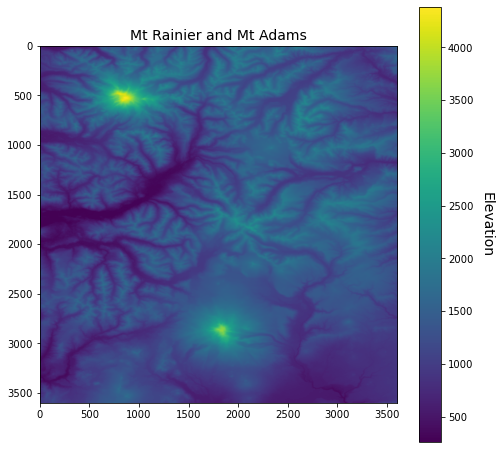

In [35]:
# Plot data
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(elevations)
ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20

## Sampling the data using points

To sample the raster data at the campsite locations we can use `Rasterio's` [`sample`](https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html) function. This function expects a list of x, y coordinate pairs so we need to convert our `geometry` column using list comprehension. 

In [36]:
coord_list = [(x,y) for x,y in zip(campsites['geometry'].x , campsites['geometry'].y)]
coord_list

[(-121.86309568977, 46.9328599291782),
 (-121.644123657629, 46.9024017663544),
 (-121.566675005534, 46.73861426056),
 (-121.794055025156, 46.7676258113237)]

Now we can carry out the sample and store the results in new column called **elevation**. Note that if the image has more than one band, a value is returned for each band.

In [37]:
campsites['elevation'] = [x for x in src.sample(coord_list)]
campsites.head()

campsite        lat         lon                     geometry elevation
0  mowich lake  46.932860 -121.863096  POINT (-121.86310 46.93286)    [1505]
1  white river  46.902402 -121.644124  POINT (-121.64412 46.90240)    [1331]
2  ohanapecosh  46.738614 -121.566675  POINT (-121.56668 46.73861)     [609]
3  cougar rock  46.767626 -121.794055  POINT (-121.79406 46.76763)     [975]

## Buffer points

Sometimes it might be a little risky to sample only one cell per point. There may be errors or artifacts in the unerlying raster. A more robust method would be to sample multiple raster grid cells surrounding a point. To do this we could **buffer** the points by a set distance and sample the raster values within the buffer.  

`GeoPandas` has a method called [`buffer`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) which expects a **distance** around each object. Since our shapefile is in WGS84 coordinate system, this distance would have to be in **degrees** which is a little confusing. A better option would be to reproject our shapefile into a **projected coordinate system** so we can enter a buffer distance in **meters**. 

In [38]:
campsites_utm = campsites.to_crs('EPSG:32610')
campsites_utm['buffer'] = campsites_utm.buffer(500)
campsites_utm

campsite        lat         lon                        geometry  \
0  mowich lake  46.932860 -121.863096  POINT (586541.645 5198330.423)   
1  white river  46.902402 -121.644124  POINT (603268.211 5195210.763)   
2  ohanapecosh  46.738614 -121.566675  POINT (609498.970 5177115.438)   
3  cougar rock  46.767626 -121.794055  POINT (592078.991 5180047.801)   

  elevation                                             buffer  
0    [1505]  POLYGON ((587041.645 5198330.423, 587039.237 5...  
1    [1331]  POLYGON ((603768.211 5195210.763, 603765.804 5...  
2     [609]  POLYGON ((609998.970 5177115.438, 609996.562 5...  
3     [975]  POLYGON ((592578.991 5180047.801, 592576.583 5...

Now we have two columns containing **geometry** values. But a `GeoDataFrame` can only have one active geometry. Since we intend to use our buffer geometry to sample the raster data, we will make our **buffer** column the active geometry.

In [39]:
campsites_utm.set_geometry('buffer', inplace=True)

We have to convert the DataFrame back to WGS84 so it has the same projection system as our raster data.

In [40]:
campsites = campsites_utm.to_crs('EPSG:4326')

## Sampling grid cells using polygons

There is a package called [`rasterstats`](https://pythonhosted.org/rasterstats/) that makes this task pretty straightforward. In the docs, it recommends installing using `pip`. We can actually do this directly from a Jupyter Notebook by using the `!` mark which allows us execute commands from the underlying operating system.

In [41]:
!pip install rasterstats

After successfully installing `rasterstats`, we can go ahead and import the function we need. 

In [42]:
from rasterstats import zonal_stats

The [`zonal_stats`](https://pythonhosted.org/rasterstats/manual.html#zonal-statistics) function requires a shapefile or polygon, a raster file or array, the geotransform of the array, and the stats we'd like to compute. 

In [76]:
stats = zonal_stats(campsites.geometry, elevations, affine=src.transform, 
            stats=['mean', 'std', 'count'], nodata=src.nodata)
stats

[{'mean': 1538.70367278798, 'count': 1198, 'std': 61.23086259469099},
 {'mean': 1380.375312760634, 'count': 1199, 'std': 75.87074248803795},
 {'mean': 638.1961602671118, 'count': 1198, 'std': 33.699186100766795},
 {'mean': 1007.7948290241868, 'count': 1199, 'std': 58.850863432257526}]

The `mean` value provides a robust measure of elevation surrounding each campsite. By including the `count` option we can see that there were 1198/1199 grid cells sampled for each 500 m buffer. The `std` option provides the variance of elevations in the buffer.

We can add these data to our original GeoDataFrame. Luckily for us, `Pandas` can implicitly convert a **list of dictionaries** to a `DataFrame`. Since `zonal_stats` preserves the order of campsites, we can use the index to **merge** the two DataFrames. 

In [75]:
campsite_stats = campsites.merge(pd.DataFrame(stats), left_index=True, right_index=True)
campsite_stats

campsite        lat         lon                        geometry  \
0  mowich lake  46.932860 -121.863096  POINT (586541.645 5198330.423)   
1  white river  46.902402 -121.644124  POINT (603268.211 5195210.763)   
2  ohanapecosh  46.738614 -121.566675  POINT (609498.970 5177115.438)   
3  cougar rock  46.767626 -121.794055  POINT (592078.991 5180047.801)   

  elevation                                             buffer         mean  \
0    [1505]  POLYGON ((-121.85653 46.93279, -121.85657 46.9...  1538.703673   
1    [1331]  POLYGON ((-121.63756 46.90232, -121.63760 46.9...  1380.375313   
2     [609]  POLYGON ((-121.56013 46.73853, -121.56018 46.7...   638.196160   
3     [975]  POLYGON ((-121.78751 46.76756, -121.78755 46.7...  1007.794829   

   count        std  median  
0   1198  61.230863  1527.0  
1   1199  75.870742  1353.0  
2   1198  33.699186   632.0  
3   1199  58.850863   986.0